In [1]:
import numpy as np
import astropy.units as u
from astropy.constants import c
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from astropy.table import Table

import SED_Model
import lrt

In [2]:
d20 = Table.read("double.20", format='ascii')
col_names = ['n_id', 'z', 'chi2', 'vec1', 'vec2', 'vec3', 'vec4', 'vec5']
for k, col_name in enumerate(col_names):
    d20.rename_column('col{}'.format(k+1),col_name)

In [3]:
d21 = Table.read("double.21", format='ascii')
col_names = ['n_id', 'jy', 'jymod', 'ejy', 'jyuse', 'lam_rest']
for k, col_name in enumerate(col_names):
    d21.rename_column('col{}'.format(k+1),col_name)

In [4]:
d22 = Table.read("double.22", format='ascii')
col_names = ['n_id', 'ebv1', 'ebv2', 'igm', 'wid']
for k, col_name in enumerate(col_names):
    d22.rename_column('col{}'.format(k+1),col_name)

In [5]:
p_data = Table.read("comp.sort", format='ascii')
p_f = dict()
for i,wid in enumerate(p_data['col1']):
    p_f[wid] = p_data['col11'][i]

In [6]:
#Use the redshifts from the Spec pipeline fits if they have been updated. 
zs = dict()
# zs['W0019-1046'] = 1.641000
# zs['W0204-0506'] = 2.099307
# zs['W0220+0137'] = 3.122
# zs['W0831+0140'] = 3.894182

In [7]:
def plot_sed(wid, ax, d20, d21, d22, p_f, zs, save_seds=False):

    #Find position of the source
    ipos = np.where(d22['wid']==wid)[0][0]

    #Read the templates
    seds = np.loadtxt("agn_spec.dat", skiprows=1)
    lam_sed = seds[:,0]*u.micron
    s = np.zeros((5, len(lam_sed)))
    for i in range(4):
        s[i] = seds[:,i+2]
    s[-1] = seds[:,2] #Secondary AGN component.

    #Read the component amplitudes and scale the SED templates.
    vec = np.zeros(5)
    for i in range(5):
        vec[i] = d20['vec{}'.format(i+1)][ipos]
    for i in range(5):
        s[i] *= vec[i]   

    #Initiate the routines to load the reddening and IGM absorption. 
    lrt.kcinit("bandmag.dat",1,1,1,0)
    nw = lrt.wavegrid.nwave

    #Apply the reddening to the AGN templates.
    s[0] *= 10**(-0.4*lrt.dust.tau[:nw]*d22['ebv1'][ipos])
    s[4] *= 10**(-0.4*lrt.dust.tau[:nw]*d22['ebv2'][ipos])

    #Apply the IGM to all the templates.
    tr_igm = np.array([lrt.transmit(lrt.wavegrid.bcen[k],d20['z'][ipos],d22['igm'][ipos]) for k in range(nw)])
    for i in range(s.shape[0]):
        s[i] *= tr_igm 

    
    #Set the quantities to plot.
    z = d20['z'][ipos]
    #z = zs[wid]

    k = np.argwhere(d21['n_id']==d20['n_id'][ipos])
    fnu      = np.stack(d21['jy'][k],axis=1)[0] * u.Jy
    fnu_mod  = np.stack(d21['jymod'][k],axis=1)[0] * u.Jy
    efnu     = np.stack(d21['ejy'][k],axis=1)[0] * u.Jy
    lam_rest = np.stack(d21['lam_rest'][k],axis=1)[0] * u.micron

    nu_rest = (c/lam_rest)
    nu_obs = nu_rest/(1.0+z)
    nu_fnu = (nu_obs * fnu).to(1e-13*u.erg/u.s/u.cm**2)
    nu_fnu_mod = (nu_obs * fnu_mod).to(1e-13*u.erg/u.s/u.cm**2)
    e_nu_fnu = (nu_obs * efnu).to(1e-13*u.erg/u.s/u.cm**2)

    #Finally put the SED template fits in the right units.
    nu_sed_obs = (c/lam_sed)/(1.+d20['z'][ipos])
    for i in range(5):
        s[i] *= nu_sed_obs.to(u.Hz).value
    s = s*u.Jy*u.Hz
    s = s.to(1e-13*u.erg/u.s/u.cm**2)


    #Plot the observed fluxes.
    #ax.plot(lam_rest, nu_fnu_mod, 'k^', markersize=10, fillstyle='none')
    ax.plot(lam_rest.value, nu_fnu.value, marker='o', markersize=8, color='lime', linestyle='none')
    ax.errorbar(lam_rest.value, nu_fnu.value, yerr=e_nu_fnu.value, fmt='o', markersize=8, color='black', fillstyle='none')

    #Plot the SED template fits.
    ax.plot(lam_sed, np.sum(s, axis=0), linestyle='solid', color='black')
    ax.plot(lam_sed, s[0], linestyle='dashed', color='magenta')
    ax.plot(lam_sed, s[1], linestyle='dotted', color='red')
    ax.plot(lam_sed, s[2], linestyle=(0,(5,10)), color='xkcd:green')
    ax.plot(lam_sed, s[3], linestyle='dashdot', color='cyan')
    ax.plot(lam_sed, s[4], linestyle='solid', color='blue')

    if save_seds:
        output = np.zeros((s.shape[0]+1, s.shape[1]))
        output[0] = lam_sed.value
        output[1:] = s.value
        np.savetxt("{}.SED.txt".format(wid), output.T)

    print(wid, z, vec[4]/vec[0])
    lam_targs = np.array([5500., 6500., 8000.])/(1+z) * u.AA
    for lam_targ in lam_targs:
        kk = np.argmin(np.abs(lam_sed-lam_targ))
        print(lam_sed[kk], s[4][kk]/(s[0][kk]+s[1][kk]+s[2][kk]+s[3][kk]+s[4][kk]))

    ax.text(0.07, 0.85, wid, transform=ax.transAxes, fontsize=15, ha='left')
    ax.text(0.07, 0.77, r'$z = {0:.3f}$'.format(z), transform=ax.transAxes, fontsize=12, ha='left')
    ax.text(0.07, 0.70, r'$p_{{\rm ran}}={0:.3f}$'.format(p_f[wid]), transform=ax.transAxes, fontsize=12, ha='left')

    return

W0019-1046 1.641 0.009765341989743919
0.2099665 micron 0.7176445088906565
0.2466891 micron 0.7010459197124164
0.3034939 micron 0.6876375816764296
W0204-0506 2.1 0.013347895282884138
0.1787105 micron 0.9735681230685611
0.2099665 micron 0.9604369208253426
0.2583152 micron 0.9442212283069225
W0220+0137 3.122 0.004307795826685638
0.1324799 micron 0.8302999400913116
0.1592759 micron 0.827975591147345
0.1959521 micron 0.7706964263261051
W0831+0140 3.912 0.008825329819528915
0.1127587 micron 0.996204875549958
0.1324799 micron 0.9951327488829156
0.1629859 micron 0.9952049510923775


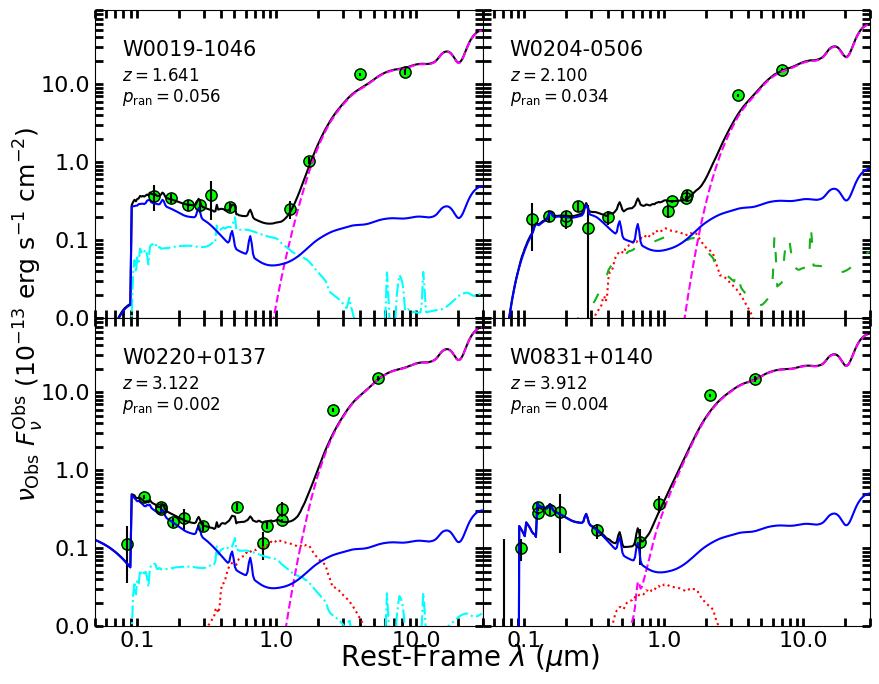

In [8]:
#Create the figure.
fig, axs = plt.subplots(2,2, figsize=(10, 8), sharex=True, sharey=True)

wids = [
    'W0019-1046',
    'W0204-0506',
    'W0220+0137',
    'W0831+0140',
]

#Set the log scale.
for ax in axs.ravel():
    ax.set_xscale('log')
    ax.set_yscale('log')

    #Set the limits.
    ax.set_xlim([0.05, 30])
    ax.set_ylim([0.01, 90.])

    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.tick_params(axis='both', which='both', direction='in', labelsize=16, width=2, length=6, top=True, right=True)

for i, ax in enumerate(axs.ravel()):
    plot_sed(wids[i], ax, d20, d21, d22, p_f, zs, save_seds=True)
    
#Set the axis labels
fig.supxlabel("Rest-Frame $\lambda$ ($\mu$m)", fontsize=20, y=0.05)
fig.supylabel(r"$\nu_{\rm Obs}~F^{\rm Obs}_{\nu}~(10^{-13}~\rm erg~\rm s^{-1}~\rm cm^{-2})$", fontsize=18, x=0.04)

#fig.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.subplots_adjust(wspace=0.0,hspace=0.0)
#fig.tight_layout()
plt.savefig("SEDs.png", dpi=200, bbox_inches='tight')

W0116-0505 3.173 0.009329226225022004
0.1324799 micron 0.9979422868378331
0.1556503 micron 0.9980774041938952
0.1914917 micron 0.9959004008575012


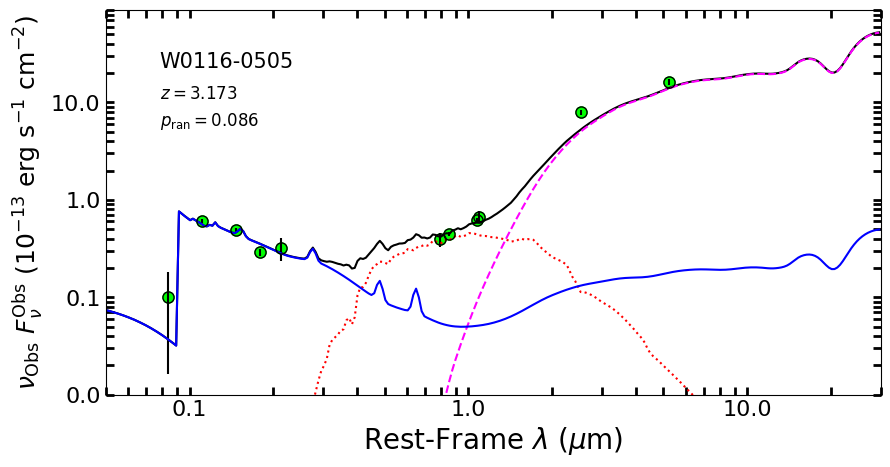

In [25]:
fig, ax = plt.subplots(1, figsize=(10,5))

ax.set_xscale('log')
ax.set_yscale('log')

#Set the limits.
ax.set_xlim([0.05, 30])
ax.set_ylim([0.01, 90.])

ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax.tick_params(axis='both', which='both', direction='in', labelsize=16, width=2, length=6, top=True, right=True)

plot_sed("W0116-0505", ax, d20, d21, d22, p_f, zs, save_seds=True)

#Set the axis labels
ax.set_xlabel("Rest-Frame $\lambda$ ($\mu$m)", fontsize=20, y=0.05)
ax.set_ylabel(r"$\nu_{\rm Obs}~F^{\rm Obs}_{\nu}~(10^{-13}~\rm erg~\rm s^{-1}~\rm cm^{-2})$", fontsize=18, x=0.04)

plt.savefig("W0116_SED.png", dpi=200, bbox_inches='tight')

W0019-1046 1.641 0.009765341989743919
0.2099665 micron 0.7176445088906565
0.2466891 micron 0.7010459197124164
0.3034939 micron 0.6876375816764296
W0204-0506 2.1 0.013347895282884138
0.1787105 micron 0.9735681230685611
0.2099665 micron 0.9604369208253426
0.2583152 micron 0.9442212283069225
W0220+0137 3.122 0.004307795826685638
0.1324799 micron 0.8302999400913116
0.1592759 micron 0.827975591147345
0.1959521 micron 0.7706964263261051
W0831+0140 3.912 0.008825329819528915
0.1127587 micron 0.996204875549958
0.1324799 micron 0.9951327488829156
0.1629859 micron 0.9952049510923775


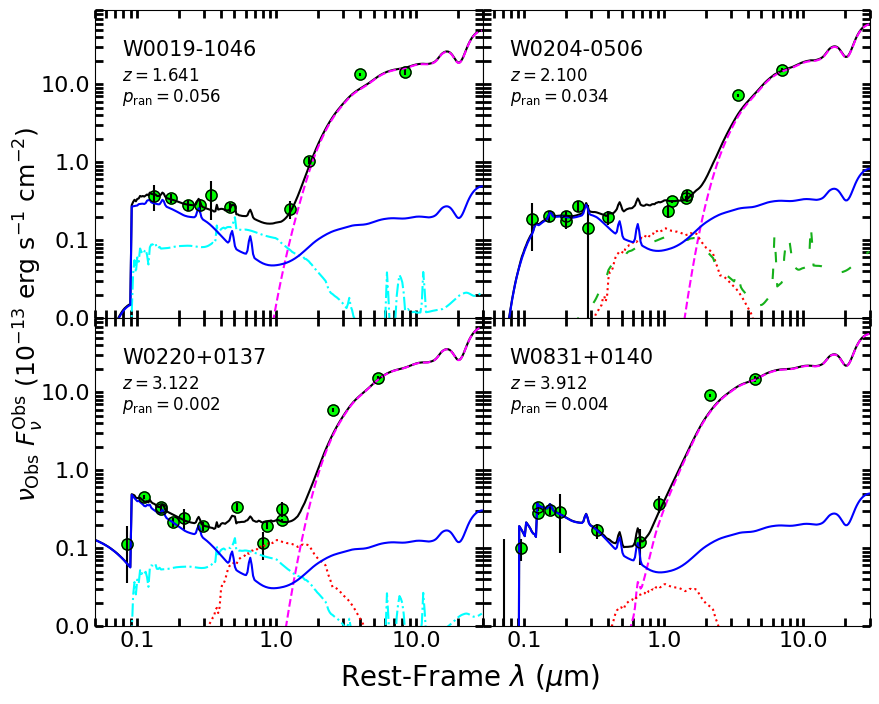

In [26]:
#Create the figure.
fig, axs = plt.subplots(2,2, figsize=(10, 8), sharex=True, sharey=True)

wids = [
    'W0019-1046',
    'W0204-0506',
    'W0220+0137',
    #'W0116-0505',
    'W0831+0140'
]

#Set the log scale.
for ax in axs.ravel():
    ax.set_xscale('log')
    ax.set_yscale('log')

    #Set the limits.
    ax.set_xlim([0.05, 30])
    ax.set_ylim([0.01, 90.])

    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.tick_params(axis='both', which='both', direction='in', labelsize=16, width=2, length=6, top=True, right=True)

for i, ax in enumerate(axs.ravel()):
    plot_sed(wids[i], ax, d20, d21, d22, p_f, zs)
    
#Set the axis labels
fig.supxlabel("Rest-Frame $\lambda$ ($\mu$m)", fontsize=20, y=0.025)
fig.supylabel(r"$\nu_{\rm Obs}~F^{\rm Obs}_{\nu}~(10^{-13}~\rm erg~\rm s^{-1}~\rm cm^{-2})$", fontsize=18, x=0.04)

#fig.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.subplots_adjust(wspace=0.0,hspace=0.0)
#fig.tight_layout()
plt.savefig("SEDs.png", dpi=200, bbox_inches='tight')

In [11]:
#We need to make a plot of the scattered light fraction as well. We can do this by dividing the best-fit secondary AGN SED and the data points by the best-fit primary model. 
def plot_scattered_sed(wid, ax, d20, d21, d22):

    #Find position of the source
    ipos = np.where(d22['wid']==wid)[0][0]

    #Read the templates
    seds = np.loadtxt("agn_spec.dat", skiprows=1)
    lam_sed = seds[:,0]*u.micron
    s = np.zeros((5, len(lam_sed)))
    for i in range(4):
        s[i] = seds[:,i+2]
    s[-1] = seds[:,2] #Secondary AGN component.

    #Read the component amplitudes and scale the SED templates.
    vec = np.zeros(5)
    for i in range(5):
        vec[i] = d20['vec{}'.format(i+1)][ipos]
    for i in range(5):
        s[i] *= vec[i]   

    #Initiate the routines to load the reddening and IGM absorption. 
    lrt.kcinit("bandmag.dat",1,1,1,0)
    nw = lrt.wavegrid.nwave

    #The scattered light spectrum will correspond to the secondary AGN (with whatever obscuration is has) divided by the primary with no obscuration. 
    scattered_fnu = s[4]*10**(-0.4*lrt.dust.tau[:nw]*d22['ebv2'][ipos]) / s[0]

    #We also apply the IGM absorption for completeness. 
    tr_igm = np.array([lrt.transmit(lrt.wavegrid.bcen[k],d20['z'][ipos],d22['igm'][ipos]) for k in range(nw)])
    scattered_fnu *= tr_igm

    #Finally put the SED template fits in the right units.
    # nu_sed_obs = (c/lam_sed)/(1.+d20['z'][ipos])
    # scattered_fnu *= nu_sed_obs.to(u.Hz).value
    # scattered_fnu = scattered_fnu*u.Jy*u.Hz
    # scattered_fnu = scattered_fnu.to(1e-13*u.erg/u.s/u.cm**2)

    #Now we need to get the band fluxes of the unobscured primary AGN component. 
    z = d20['z'][ipos]
    agn1 = SED_Model.lrt_model()
    agn1.z = z
    agn1.zspec = z
    agn1.ebv = 0.
    agn1.igm = d22['igm'][ipos]
    agn1.comp = np.zeros(4)
    agn1.comp[0] = 1.0
    agn1.comp[0] *= d20['vec1'][ipos] / agn1.vec[0]
    agn1.get_model_fluxes()

    #Also, we need the host galaxy ones to substract them.
    gal = SED_Model.lrt_model()
    gal.z = z
    gal.zspec = z
    gal.ebv = 0.
    gal.igm = d22['igm'][ipos]
    gal.comp = np.ones(4)
    gal.comp[0] = 0.
    norm = np.array(list(d20['vec2','vec3','vec4'][ipos])) / gal.vec[1:]
    gal.comp[1:] *= norm
    gal.get_model_fluxes()

    # #Get also the observed fluxes. 
    # k = np.argwhere(d21['n_id']==d20['n_id'][ipos])
    # fnu      = np.stack(d21['jy'][k],axis=1)[0] * u.Jy
    # fnu_mod  = np.stack(d21['jymod'][k],axis=1)[0] * u.Jy
    # efnu     = np.stack(d21['ejy'][k],axis=1)[0] * u.Jy
    # lam_rest = np.stack(d21['lam_rest'][k],axis=1)[0] * u.micron

    # nu_rest = (c/lam_rest)
    # nu_obs = nu_rest/(1.0+z)
    # nu_fnu = (nu_obs * fnu).to(1e-13*u.erg/u.s/u.cm**2)
    # nu_fnu_mod = (nu_obs * fnu_mod).to(1e-13*u.erg/u.s/u.cm**2)
    # e_nu_fnu = (nu_obs * efnu).to(1e-13*u.erg/u.s/u.cm**2)

    #The scattered light fluxes will correspond to the observed fluxes divided by the expected fluxes from the primary AGN without absorption.
    k = np.argwhere(d21['n_id']==d20['n_id'][ipos])
    fnu_band_scatt  = (np.stack(d21['jy'][k],axis=1)[0] - gal.jymod) / agn1.jymod
    efnu_band_scatt = np.stack(d21['ejy'][k],axis=1)[0] / agn1.jymod
    lam_rest = np.stack(d21['lam_rest'][k],axis=1)[0] * u.micron

    #Apply the reddening to the AGN templates.
    #s[0] *= 10**(-0.4*lrt.dust.tau[:nw]*d22['ebv1'][ipos])
    #s[4] *= 10**(-0.4*lrt.dust.tau[:nw]*d22['ebv2'][ipos])

    #Apply the IGM to all the templates.
    #tr_igm = np.array([lrt.transmit(lrt.wavegrid.bcen[k],d20['z'][ipos],d22['igm'][ipos]) for k in range(nw)])
    #for i in range(s.shape[0]):
    #    s[i] *= tr_igm 


    #Plot the observed scattered fluxes.
    #ax.plot(lam_rest, nu_fnu_mod, 'k^', markersize=10, fillstyle='none')
    ax.plot(lam_rest.value, fnu_band_scatt, marker='o', markersize=8, color='lime', linestyle='none')
    ax.errorbar(lam_rest.value, fnu_band_scatt, yerr=efnu_band_scatt, fmt='o', markersize=8, color='black', fillstyle='none')

    #Plot the SED template fits.
    ax.plot(lam_sed, scattered_fnu, ls='solid', c='black')
    # ax.plot(lam_sed, np.sum(s, axis=0), linestyle='solid', color='black')
    # ax.plot(lam_sed, s[0], linestyle='dashed', color='magenta')
    # ax.plot(lam_sed, s[1], linestyle='dotted', color='red')
    # ax.plot(lam_sed, s[2], linestyle=(0,(5,10)), color='xkcd:green')
    # ax.plot(lam_sed, s[3], linestyle='dashdot', color='cyan')
    # ax.plot(lam_sed, s[4], linestyle='solid', color='blue')

    # if save_seds:
    #     output = np.zeros((s.shape[0]+1, s.shape[1]))
    #     output[0] = lam_sed.value
    #     output[1:] = s.value
    #     np.savetxt("{}.SED.txt".format(wid), output.T)

    # print(wid, z, vec[4]/vec[0])
    # lam_targs = np.array([5500., 6500., 8000.])/(1+z) * u.AA
    # for lam_targ in lam_targs:
    #     kk = np.argmin(np.abs(lam_sed-lam_targ))
    #     print(lam_sed[kk], s[4][kk]/(s[0][kk]+s[1][kk]+s[2][kk]+s[3][kk]+s[4][kk]))

    ax.text(0.07, 0.85, wid, transform=ax.transAxes, fontsize=15, ha='left')
    ax.text(0.07, 0.77, r'$z = {0:.3f}$'.format(z), transform=ax.transAxes, fontsize=12, ha='left')
    #ax.text(0.07, 0.70, r'$p_{{\rm ran}}={0:.3f}$'.format(p_f[wid]), transform=ax.transAxes, fontsize=12, ha='left')

    return


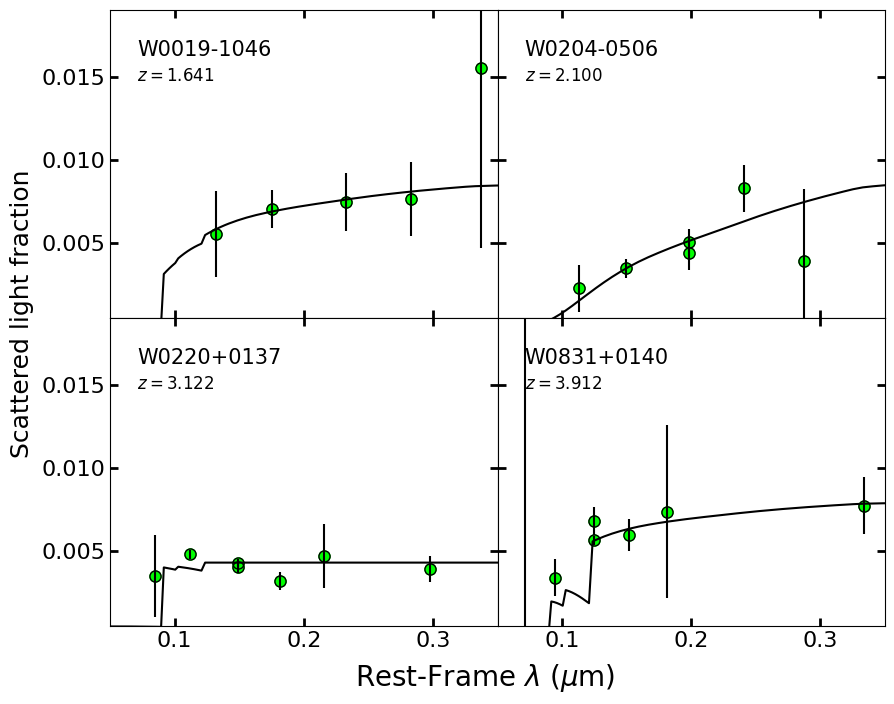

In [18]:
#Create the figure.
fig, axs = plt.subplots(2,2, figsize=(10, 8), sharex=True, sharey=True)

wids = [
    'W0019-1046',
    'W0204-0506',
    'W0220+0137',
    #'W0116-0505',
    'W0831+0140'
]

#Set the log scale.
for ax in axs.ravel():
    #ax.set_xscale('log')
    #ax.set_yscale('log')

    #Set the limits.
    ax.set_xlim([0.05, 0.35])
    ax.set_ylim([0.0005, 0.019])

    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.tick_params(axis='both', which='both', direction='in', labelsize=16, width=2, length=6, top=True, right=True)

for i, ax in enumerate(axs.ravel()):
    plot_scattered_sed(wids[i], ax, d20, d21, d22)
    
#Set the axis labels
fig.supxlabel("Rest-Frame $\lambda$ ($\mu$m)", fontsize=20, y=0.025)
fig.supylabel("Scattered light fraction", fontsize=18, x=0.025)

#fig.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.subplots_adjust(wspace=0.0,hspace=0.0)
#fig.tight_layout()
plt.savefig("Scattered_light_fractions.png", dpi=200, bbox_inches='tight')

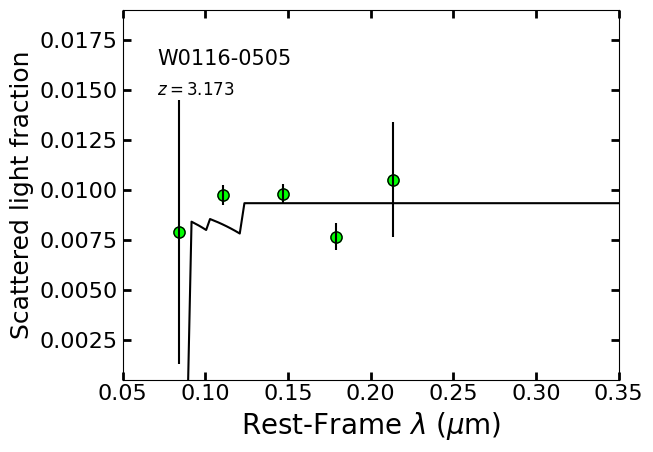

In [23]:
fig, ax = plt.subplots(1)

#ax.set_xscale('log')
#ax.set_yscale('log')

#Set the limits.
ax.set_xlim([0.05, 0.35])
ax.set_ylim([0.0005, 0.019])

ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax.tick_params(axis='both', which='both', direction='in', labelsize=16, width=2, length=6, top=True, right=True)

plot_scattered_sed("W0116-0505", ax, d20, d21, d22)

ax.set_xlabel("Rest-Frame $\lambda$ ($\mu$m)", fontsize=20, y=0.025)
ax.set_ylabel("Scattered light fraction", fontsize=18, x=0.025)

plt.savefig("W0116_Scattered_light_fraction.png", dpi=200, bbox_inches='tight')

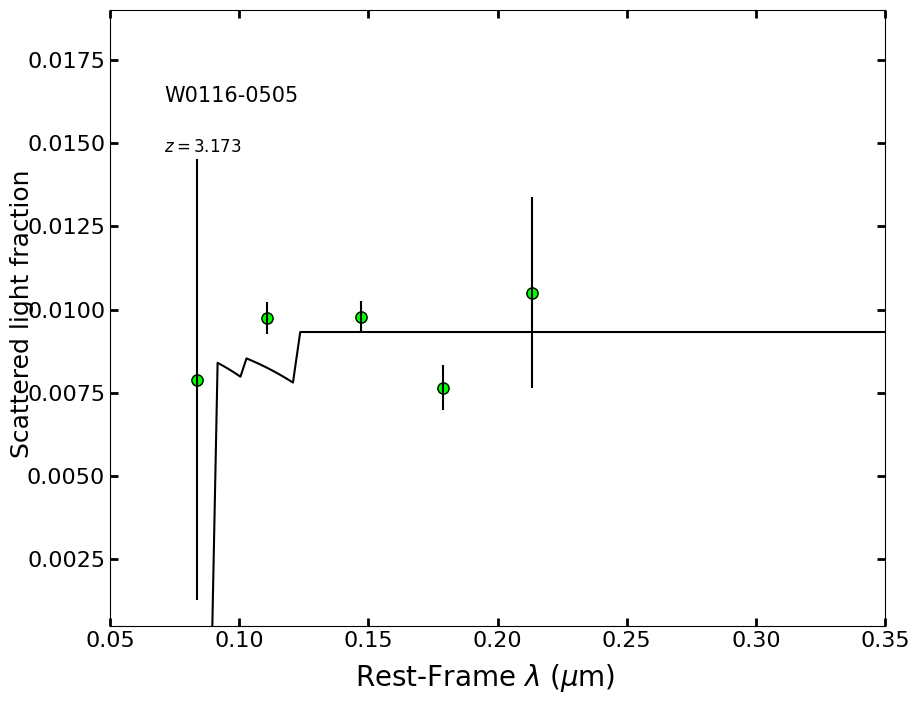

In [17]:
#Create the figure.
fig, ax = plt.subplots(1,1, figsize=(10, 8), sharex=True, sharey=True)

wids = [
    # 'W0019-1046',
    # 'W0204-0506',
    # 'W0220+0137',
    'W0116-0505',
]

#Set the log scale.
#ax.set_xscale('log')
#ax.set_yscale('log')

#Set the limits.
ax.set_xlim([0.05, 0.35])
ax.set_ylim([0.0005, 0.019])

ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax.tick_params(axis='both', which='both', direction='in', labelsize=16, width=2, length=6, top=True, right=True)

plot_scattered_sed(wids[0], ax, d20, d21, d22)
    
#Set the axis labels
fig.supxlabel("Rest-Frame $\lambda$ ($\mu$m)", fontsize=20, y=0.025)
fig.supylabel("Scattered light fraction", fontsize=18, x=0.025)

#fig.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.subplots_adjust(wspace=0.0,hspace=0.0)
#fig.tight_layout()
#plt.savefig("Scattered_light_fractions.png", dpi=200, bbox_inches='tight')

In [13]:
ipos = 1
#Now we need to get the band fluxes of the unobscured primary AGN component. 
z = d20['z'][ipos]
gal = SED_Model.lrt_model()
gal.z = z
gal.zspec = z
gal.ebv = 0.
gal.igm = d22['igm'][ipos]
gal.comp = np.zeros(4)
gal.comp[0] = 1.0
gal.comp[0] *= d20['vec1'][ipos] / gal.vec[0]
gal.get_model_fluxes()

np.array(list(d20['vec2','vec3','vec4'][ipos])) / gal.vec[1:]

/var/folders/p7/drxzchtj4yb641v79lt0tjyh0000gn/T/ipykernel_58590/1427317762.py:14: RuntimeWarning: divide by zero encountered in divide
  np.array(list(d20['vec2','vec3','vec4'][ipos])) / gal.vec[1:]
/var/folders/p7/drxzchtj4yb641v79lt0tjyh0000gn/T/ipykernel_58590/1427317762.py:14: RuntimeWarning: invalid value encountered in divide
  np.array(list(d20['vec2','vec3','vec4'][ipos])) / gal.vec[1:]


array([nan, nan, inf])